# Stellar Origin

In [161]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
from auriga.snapshot import Snapshot
from auriga.images import figure_setup
from auriga.paths import Paths
from auriga.parser import parse
from auriga.settings import Settings

In [162]:
figure_setup()

In [163]:
def read_data(simulation: str) -> tuple:
    """
    Read the properties of interest for this analysis.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    s = Snapshot(simulation=simulation,
                 loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(disc_std_circ=1.0,
                              disc_min_circ=0.4,
                              cold_disc_delta_circ=0.25,
                              bulge_max_specific_energy=-0.75)
    s.add_stellar_origin()

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    return (s.stellar_origin_idx[is_real_star & is_main_obj],
        s.region_tag[is_real_star & is_main_obj])

In [164]:
def prepare_data(stellar_origin_idx: np.ndarray,
                 region_tag: np.ndarray,
                 ) -> tuple:
    """
    This method takes the halo/subhalo index of birth for the stars and the
    region tag and returns a tuple with the ordered values of in-situ
    stellar percentages, labels and colors.

    Parameters
    ----------
    stellar_origin_idx : np.ndarray
        The halo/subhalo index of birth for the stars.
    region_tag : np.ndarray
        The region tag.

    Returns
    -------
    tuple
        The prepared data.
    """

    settings = Settings()

    # Bar widths
    bar_widths = np.array(
        [((stellar_origin_idx[:, 0] == 0)
        & (stellar_origin_idx[:, 1] == 0)).sum() / stellar_origin_idx.shape[0],
        ((stellar_origin_idx[region_tag == 0, 0] == 0)
        & (stellar_origin_idx[region_tag == 0, 1] == 0)).sum() / \
            stellar_origin_idx[region_tag == 0].shape[0],
        ((stellar_origin_idx[region_tag == 1, 0] == 0)
        & (stellar_origin_idx[region_tag == 1, 1] == 0)).sum() / \
            stellar_origin_idx[region_tag == 1].shape[0],
        ((stellar_origin_idx[region_tag == 2, 0] == 0)
        & (stellar_origin_idx[region_tag == 2, 1] == 0)).sum() / \
            stellar_origin_idx[region_tag == 2].shape[0],
        ((stellar_origin_idx[region_tag == 3, 0] == 0)
        & (stellar_origin_idx[region_tag == 3, 1] == 0)).sum() / \
            stellar_origin_idx[region_tag == 3].shape[0],
        ]) 

    # Numerical labels
    num_labels = np.array([
        r"$\textbf{" + str(np.round(100 * item, 1)) \
            + r"\%" "}$" for item in bar_widths])

    # Categorical labels
    labels = np.array(
        ["Galaxy"] + [
        item.replace(" ", "\n") for item in \
            settings.component_labels.values()])

    # Colors
    colors = np.array(["tab:gray"] + list(settings.component_colors.values()))

    order_idx = np.argsort(bar_widths)
    return (bar_widths[order_idx], num_labels[order_idx],
        labels[order_idx], colors[order_idx])

In [165]:
def create_in_situ_plot_for_galaxy(simulation: str):
    stellar_origin_idx, region_tag = read_data(simulation=simulation)
    bar_widths, num_labels, labels, colors = prepare_data(
        stellar_origin_idx=stellar_origin_idx,
        region_tag=region_tag)

    fig = plt.figure(figsize=(3.0, 2.5))
    gs = fig.add_gridspec(nrows=1, ncols=1, hspace=0.0, wspace=0.0)
    ax = gs.subplots(sharex=True, sharey=True)

    ax.label_outer()
    ax.tick_params(which='both', direction="in",
                bottom=False, top=False, left=False, right=False)
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 20, 40, 60, 80, 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    hbars = ax.barh(y=np.arange(bar_widths.shape[0]),
                    width=100 * bar_widths,
                    color=colors,
                    linewidth=0)
    ax.bar_label(hbars, labels=num_labels, padding=-30,)
    ax.set_yticks(np.arange(bar_widths.shape[0]), labels=labels)
    ax.set_xlabel('In-Situ Star Percentage')

    ax.text(x=ax.get_xlim()[0],
            y=ax.get_ylim()[1],
            s=r"$\texttt{" + simulation.upper() + "}$",
            size=8.0,
            ha='left', va='bottom',
            )

    plt.show()

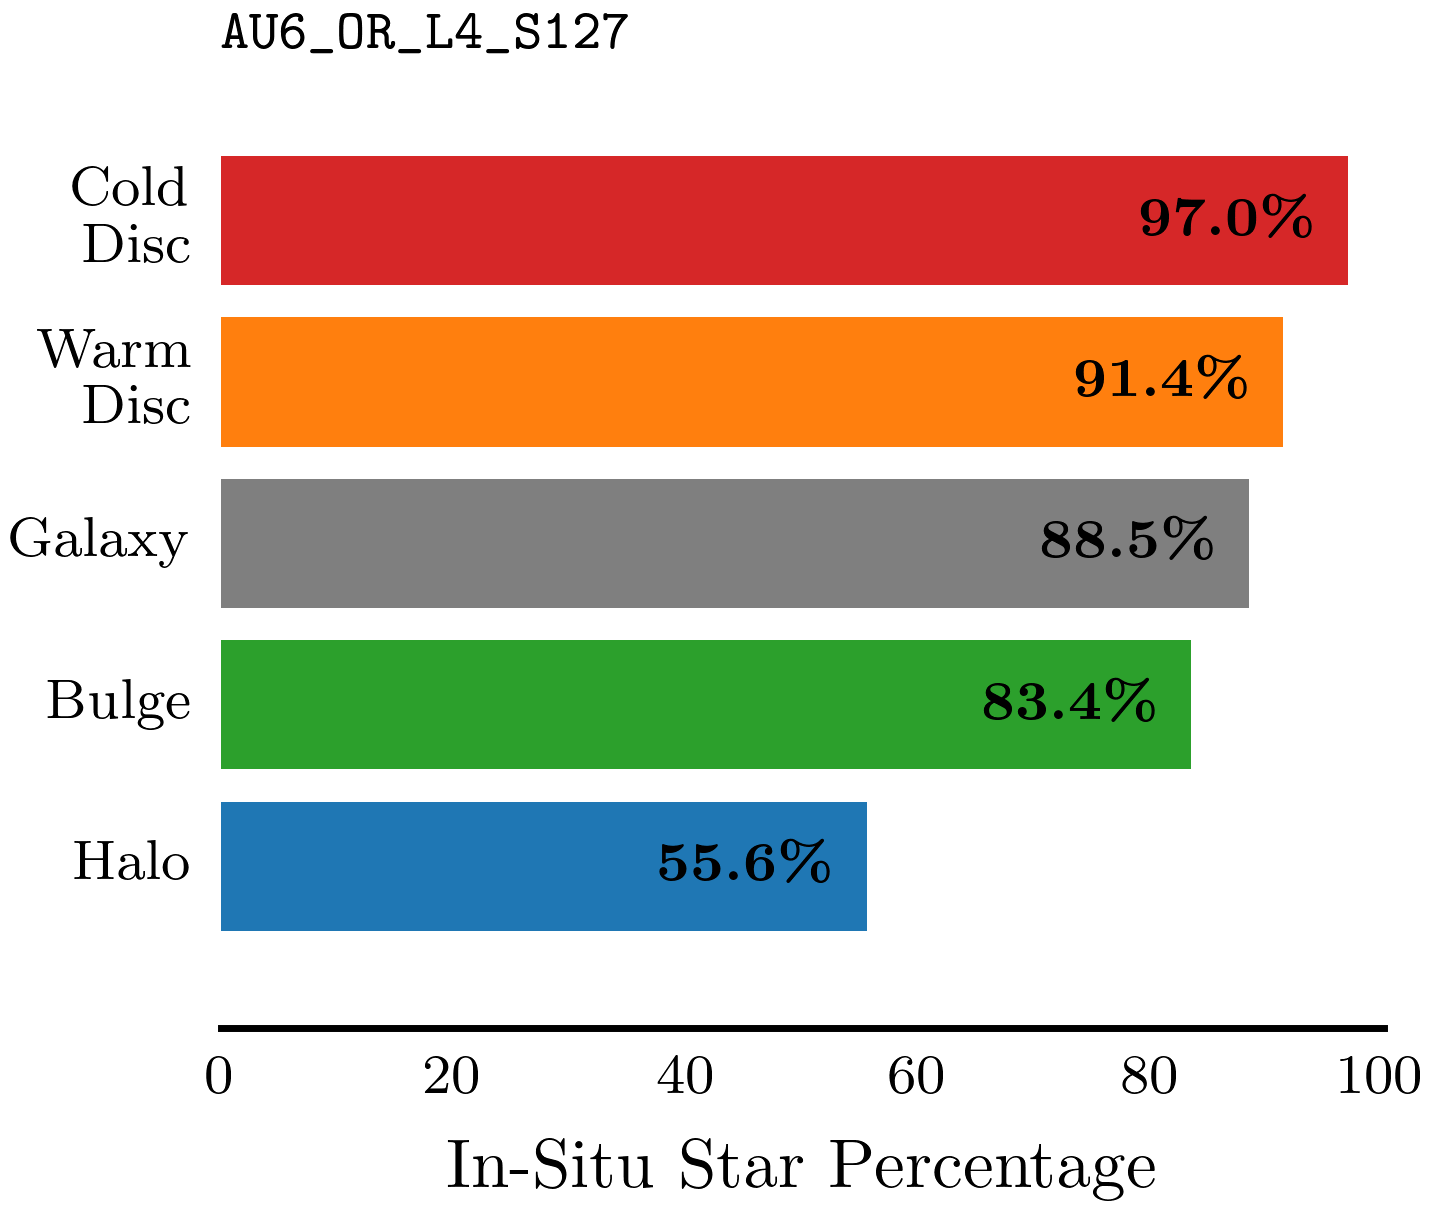

In [166]:
create_in_situ_plot_for_galaxy(simulation="au6_or_l4_s127")